In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
#jtplot.style()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # display all columns
#pd.set_option('display.max_rows', None) # display all columns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

Решением будет ссылка на гитхаб с ноутбуком.

In [100]:
data = pd.read_csv('adult.csv')


In [101]:
data.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [103]:
# У нас там знаки вопросов есть-за меним их на частовсречающиейся значения
for col in l:
    #print(data[col].unique())
    if '?' in data[col].unique():
    #print(data[t].value_counts().index[0])
        print(col)
        data[col][data[col]=='?']=data[col].value_counts().index[0]

workclass
occupation
native-country


In [105]:
#Выделим целевую переменную
y=data['income'].apply(lambda x: 0 if x=='<=50K' else 1  )

In [106]:
X=data.iloc[:, :-1]#Уберем  цлевую переменную


In [107]:
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States


In [108]:
numeric_variables = list(X.select_dtypes(include=['int64']).columns.values)

In [109]:

#Сделаем дамми для категориальных переменных
X = pd.get_dummies(X)

In [110]:
from sklearn.preprocessing import StandardScaler
#Нормализуем численные переменные
features=X[numeric_variables]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X[numeric_variables] = features

In [111]:
#Проверим насколько наши классы сбалансированы-не очень где-то 1 к 3. Значит AUC актуальна
y.value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [112]:
# Сформируем трейн и тест сеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Найндем наилучшую конфигурацию для логистической регрессии. Сет у нас большоей 5 фолдов более, чем достоточно.

In [134]:
%%time
lr_params = {
    
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 0.25, 0.5]
}
lr = LogisticRegression()
grid_lr = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y_train)

Wall time: 1min 18s


In [135]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

{'C': 0.25, 'penalty': 'l2'}
0.9044491823469698
LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


AUC= 0.907021871333691


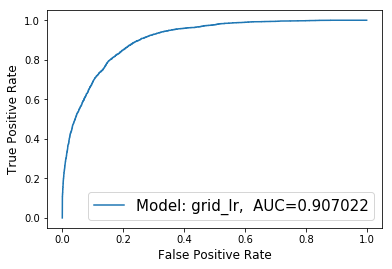

In [295]:
predictions_lr = grid_lr.predict_proba(X_test)
fpr_lr, tpr_lr, thres_lr = roc_curve( y_test, predictions_lr[:, 1] )
plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_lr',roc_auc_score( y_test, predictions_lr[:, 1]),linestyle='--' ))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend( loc = 4, prop={'size': 15})
print('AUC=',roc_auc_score( y_test, predictions_lr[:, 1] ))



Тоже самое для дерева

In [139]:

%%time
from sklearn.tree import DecisionTreeClassifier
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(tree, tree_params, scoring='roc_auc', cv=5)
grid_tree.fit(X_train, y_train)





Wall time: 1min 59s


In [140]:
print(grid_tree.best_params_)
print(grid_tree.best_score_)
print(grid_tree.best_estimator_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 16}
0.9040383545425982
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


AUC= 0.9065127895103904


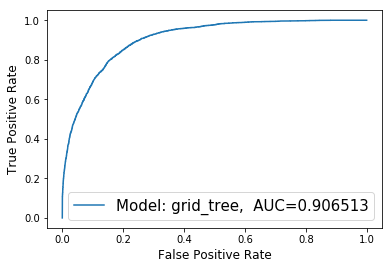

In [296]:
predictions_tree = grid_tree.predict_proba(X_test)
fpr_tree, tpr_tree, thres_tree = roc_curve( y_test, predictions_tree[:, 1] )

plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_tree',roc_auc_score( y_test, predictions_tree[:, 1]),linestyle='--' ))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend( loc = 4, prop={'size': 15})
print('AUC=',roc_auc_score( y_test, predictions_tree[:, 1] ))


In [ ]:
Тоже самое для леса

In [250]:
%%time
from sklearn.ensemble import RandomForestClassifier
forest_params = {
    'n_estimators': [5, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}
forest = RandomForestClassifier()
grid_forest = GridSearchCV(forest, forest_params, scoring='roc_auc', cv=5,n_jobs=-1)
grid_forest.fit(X_train, y_train)

Wall time: 40.6 s


In [251]:
print(grid_forest.best_params_)
print(grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 40}
0.9152303385566227
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


AUC= 0.9162875014662055


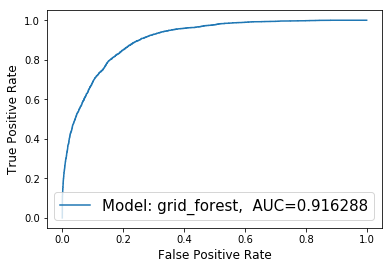

In [297]:
predictions_forest = grid_forest.predict_proba(X_test)
fpr_forest, tpr_forest, thres_forest = roc_curve( y_test, predictions_forest[:, 1] )

plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_forest',roc_auc_score( y_test, predictions_forest[:, 1]),linestyle='--' ))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend( loc = 4, prop={'size': 15})
print('AUC=',roc_auc_score( y_test, predictions_forest[:, 1] ))



Тоже самое для knn

In [253]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn_params = {
    #'n_neighbors': [1, 3]
    'n_neighbors': [1, 3, 5, 9,25],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, knn_params, scoring='roc_auc', cv=5,n_jobs=-1)
grid_knn.fit(X_train, y_train)

Wall time: 9min 6s


In [254]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)

{'n_neighbors': 25, 'p': 2}
0.894197174932807
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')


AUC= 0.8956865696592017


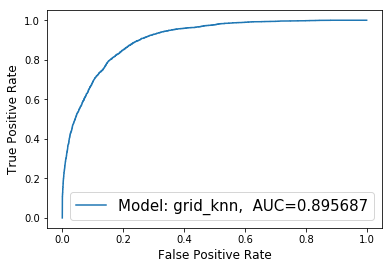

In [305]:
predictions_knn = grid_knn.predict_proba(X_test)
fpr_knn, tpr_knn, thres_knn = roc_curve( y_test, predictions_knn[:, 1] )

plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_knn',roc_auc_score( y_test, predictions_knn[:, 1]),linestyle='--' ))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend( loc = 4, prop={'size': 15})
print('AUC=',roc_auc_score( y_test, predictions_knn[:, 1] ))


Тоже самое для SVC

In [256]:
%%time
from sklearn.svm import SVC

svc_params = {
    'C': [0.001, 0.01, 0.1, 0.25, 0.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc = SVC()
grid_svc = GridSearchCV(svc, svc_params, scoring='roc_auc', cv=5,n_jobs=-1Тоже самое для knn)
grid_svc.fit(X_train, y_train)

Wall time: 17min 43s


In [257]:
print(grid_svc.best_params_)
print(grid_svc.best_score_)
print(grid_svc.best_estimator_)

{'C': 0.5, 'kernel': 'rbf'}
0.9036297023867709
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


AUC= 0.9060377770873996


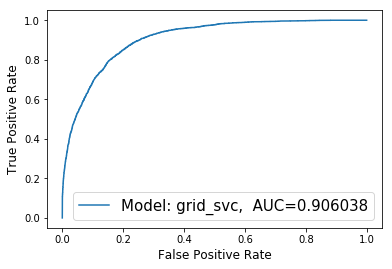

In [304]:
predictions_svc=grid_svc.decision_function(X_test)
fpr_svc, tpr_svc, thres_svc = roc_curve( y_test, predictions_svc)

plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_svc',roc_auc_score( y_test, predictions_svc),linestyle='--' ))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend( loc = 4, prop={'size': 15})
print('AUC=',roc_auc_score( y_test, predictions_svc ))

In [ ]:
Нарисуем всем  вместе

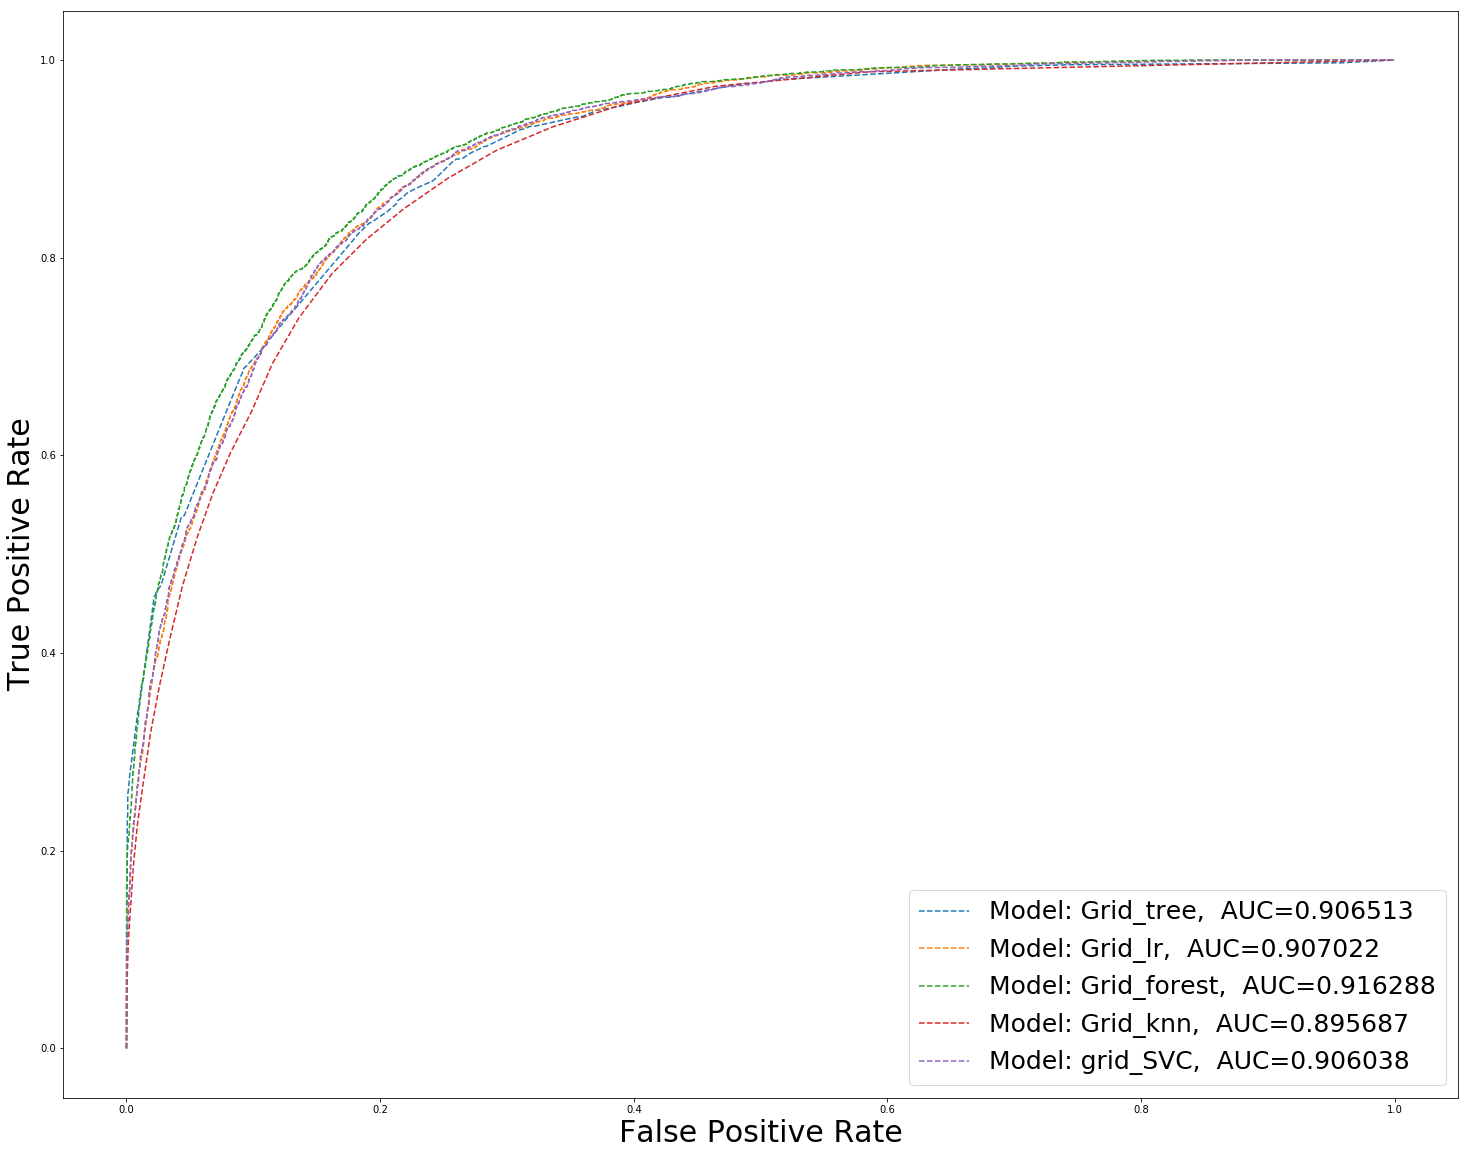

In [302]:
models=['grid_tree','grid_lr','grid_forest','grid_knn']
plt.figure( figsize=(25, 20))

for model in models:
    #print(model)
    fpr, tpr, thres = roc_curve( y_test, eval(model).predict_proba(X_test)[:, 1] )
    AUC= roc_auc_score( y_test, eval(model).predict_proba(X_test)[:, 1])#знаю, необазательно каждый раз
    #считать это, просто для тренирвки
   
    plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( model.capitalize(),AUC),linestyle='--')

#У SVC другой немножко способ расчета вне цикла посчитаем    
AUC= roc_auc_score( y_test, grid_svc.decision_function(X_test)  )
fpr, tpr, thres = roc_curve( y_test, grid_svc.decision_function(X_test))
plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_SVC',AUC),linestyle='--' )

plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate', fontsize=30)
plt.legend( loc = 4, prop={'size': 25})
plt.show()

В целом мы получили достаточно близкие оценки AUC.Это скорее всего объяснить тем, что сет у нас большой а грид и кросс-валидацией даже дереву не дал возможности сильно переобучиться. Лучшим оказался случайный лес.

In [285]:
#Более детальные метрики по лесу
from sklearn.metrics import classification_report
print(classification_report( y_test,grid_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11118
           1       0.78      0.59      0.67      3535

   micro avg       0.86      0.86      0.86     14653
   macro avg       0.83      0.77      0.79     14653
weighted avg       0.86      0.86      0.85     14653



In [306]:
# Как распределятся наши прдесказания леса
from sklearn.metrics import confusion_matrix
confusion_matrix( y_test, grid_forest.predict(X_test))


array([[10534,   584],
       [ 1444,  2091]], dtype=int64)